In [1]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F
import optuna
import tensorboard
from lightning.pytorch.loggers import TensorBoardLogger

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

import torchclustermetrics 
reload(torchclustermetrics)
from torchclustermetrics import silhouette

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head(), df_transcripts.shape

(     transcript_id  cell_id  overlaps_nucleus feature_name  x_location  \
 0  281474976710657   191815                 1          LUM   4797.2383   
 1  281474976710663   214084                 1       SEC11C   4801.7330   
 2  281474976710672   191342                 0         TCIM   4804.4920   
 3  281474976710673   191574                 0         STC1   4805.0483   
 4  281474976710674   192193                 0         STC1   4805.7170   
 
    y_location  z_location         qv  
 0   550.61346   15.421524  18.445875  
 1   905.11600   14.925031  31.019386  
 2   596.05396   14.681485  22.270780  
 3   414.38370   19.306356  16.183300  
 4   273.81440   16.112896  26.251837  ,
 (43775350, 8))

In [3]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(100)
clustering.create_spot_data(third_dim=False, save_data=True)

In [4]:
valid_genes_mask = ~clustering.xenium_spot_data.var_names.str.startswith('BLANK_') & ~clustering.xenium_spot_data.var_names.str.startswith('NegControl')
clustering.xenium_spot_data = clustering.xenium_spot_data[:, valid_genes_mask]

In [5]:
clustering.normalize_counts(clustering.xenium_spot_data)

In [6]:
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=5)
clustering.xenium_spot_data.obsm["X_pca"].shape

(7312, 5)

In [8]:
NUM_CLUSTERS = 4
BATCH_SIZE = 32

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

# Load the data (5 PCs for each spot)
data = torch.tensor(clustering.xenium_spot_data.obsm["X_pca"]).float()

def model(data):
    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=BATCH_SIZE) as ind:
        batch_data = data[ind]
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(torch.ones(BATCH_SIZE, NUM_CLUSTERS)))
        
        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(0., 1.).expand([NUM_CLUSTERS, batch_data.size(1)]).to_event(2))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(0., 1.).expand([NUM_CLUSTERS, batch_data.size(1)]).to_event(2))
        
        # Likelihood of data given cluster assignments
        pyro.sample("obs", dist.MixtureOfDiagNormals(cluster_means, cluster_scales, cluster_probs).to_event(1), obs=batch_data)

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", torch.ones(data.size(0), NUM_CLUSTERS), constraint=dist.constraints.positive)
    # Global variational parameters for means and scales
    cluster_means_q = pyro.param("cluster_means_q", torch.randn(NUM_CLUSTERS, data.size(1)))
    cluster_scales_q = pyro.param("cluster_scales_q", torch.ones(NUM_CLUSTERS, data.size(1)), constraint=dist.constraints.positive)
    
    with pyro.plate("data", len(data), subsample_size=BATCH_SIZE) as ind:

        batch_cluster_concentration_params_q = cluster_concentration_params_q[ind]

        # pyro.sample("cluster_assignments", dist.Categorical(batch_cluster_probs_q))
        pyro.sample("cluster_probs", dist.Dirichlet(batch_cluster_concentration_params_q))
        pyro.sample("cluster_means", dist.Normal(cluster_means_q, 0.1).to_event(2))
        pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q, 0.1).to_event(2))

# Setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# Setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=10))

# Do gradient steps
N_STEPS = 10000
for step in range(N_STEPS):
    loss = svi.step(data)
    if step % 100 == 0:
        print(f"Step {step} : loss = {round(loss/1e6, 4)}")

Step 0 : loss = 8.5796
Step 100 : loss = 7.4252
Step 200 : loss = 6.7282
Step 300 : loss = 6.2992
Step 400 : loss = 5.709
Step 500 : loss = 5.456
Step 600 : loss = 4.9435
Step 700 : loss = 4.7688
Step 800 : loss = 4.5589
Step 900 : loss = 4.4071
Step 1000 : loss = 4.3503
Step 1100 : loss = 4.2976
Step 1200 : loss = 4.326
Step 1300 : loss = 4.3117
Step 1400 : loss = 4.2038
Step 1500 : loss = 4.2707
Step 1600 : loss = 4.2456
Step 1700 : loss = 4.2077
Step 1800 : loss = 4.1747
Step 1900 : loss = 4.1644
Step 2000 : loss = 4.2164
Step 2100 : loss = 4.1589
Step 2200 : loss = 4.1683
Step 2300 : loss = 4.1852
Step 2400 : loss = 4.1715
Step 2500 : loss = 4.1251
Step 2600 : loss = 4.12
Step 2700 : loss = 4.066
Step 2800 : loss = 4.0983
Step 2900 : loss = 4.0861
Step 3000 : loss = 4.1239
Step 3100 : loss = 4.1231
Step 3200 : loss = 4.1099
Step 3300 : loss = 4.044
Step 3400 : loss = 4.0949
Step 3500 : loss = 4.1228
Step 3600 : loss = 4.0803


KeyboardInterrupt: 

In [23]:
# Grab the learned variational parameters
cluster_concentration_params_q = pyro.param("cluster_concentration_params_q")
cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q))
cluster_concentration_params_q = cluster_concentration_params_q.detach().numpy()

cluster_assigments_q = cluster_probs_q.argmax(dim=1)
cluster_means_q = pyro.param("cluster_means_q").detach().numpy()
cluster_scales_q = pyro.param("cluster_scales_q").detach().numpy()

# Output the learned cluster probabilities for each data point
print(cluster_assigments_q, cluster_probs_q)

tensor([1, 1, 1,  ..., 1, 1, 1]) tensor([[6.4695e-04, 8.6423e-01, 1.3487e-01, 2.5968e-04],
        [1.0050e-03, 9.7180e-01, 2.3050e-02, 4.1424e-03],
        [2.6266e-01, 5.5484e-01, 1.7149e-01, 1.1010e-02],
        ...,
        [3.3648e-03, 9.5082e-01, 4.0493e-02, 5.3195e-03],
        [6.6581e-02, 8.5483e-01, 7.5860e-04, 7.7833e-02],
        [9.2070e-04, 9.3094e-01, 3.0364e-02, 3.7776e-02]],
       grad_fn=<_DirichletBackward>)


(array([2126.,    0.,    0., 2280.,    0.,    0., 2427.,    0.,    0.,
         479.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

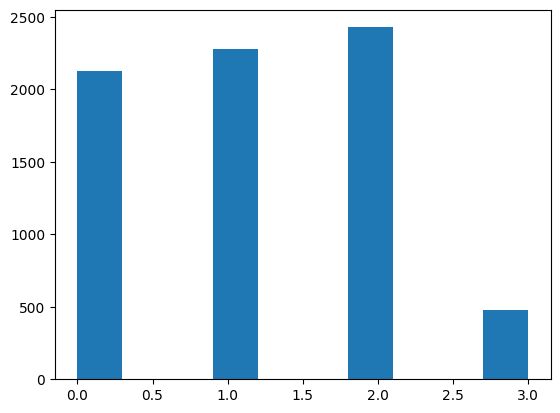

In [24]:
plt.hist(cluster_assigments_q)

In [25]:
np.set_printoptions(suppress=True) 
np.round(cluster_means_q, 4), np.round(cluster_scales_q, 4)

(array([[-0.1881,  0.6656,  0.0076,  0.2542,  0.5973],
        [ 0.2222, -1.5786,  1.3445,  0.3476, -0.7751],
        [-0.2297, -0.2434, -0.9732, -0.3324, -0.0839],
        [-0.0108,  0.3668, -0.2916, -0.4146, -0.0281]], dtype=float32),
 array([[2.5224, 2.0016, 1.3595, 1.1831, 0.8037],
        [3.0266, 1.3954, 0.0182, 0.0173, 0.0178],
        [2.7933, 1.4584, 0.229 , 0.7807, 0.7788],
        [0.9731, 0.8613, 0.6602, 1.0165, 0.3106]], dtype=float32))

In [26]:
rows = clustering.xenium_spot_data.obs["row"].astype(int)
columns = clustering.xenium_spot_data.obs["col"].astype(int)

num_rows = int(max(rows) - min(rows) + 1)
num_cols = int(max(columns) - min(columns) + 1)

In [27]:
cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = cluster_assigments_q

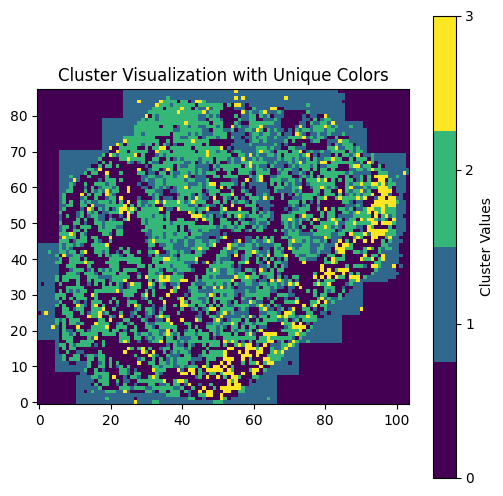

In [28]:
colors = plt.cm.get_cmap('viridis', NUM_CLUSTERS)
colormap = ListedColormap(colors(np.linspace(0, 1, NUM_CLUSTERS)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(NUM_CLUSTERS), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()